# Importing The Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
import math  # standard Python math module
import warnings
# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Enable inline plotting for Jupyter/Colab
%matplotlib inline

#Loading and Reading the Dataset

In [2]:
from google.colab import files
# Upload file manually
uploaded = files.upload()

Saving online_retail_II.xlsx to online_retail_II.xlsx


In [3]:
file_name = "online_retail_II.xlsx"  # Make sure the filename matches
data = pd.ExcelFile(file_name)
# Check available sheets
print(data.sheet_names)

['Year 2009-2010', 'Year 2010-2011']


#Merge and Preparing the Dataset



In [4]:
# Read both sheets and merge them
df_2009_2010 = pd.read_excel(data, sheet_name='Year 2009-2010')
df_2010_2011 = pd.read_excel(data, sheet_name='Year 2010-2011')
# Combine the data
data = pd.concat([df_2009_2010, df_2010_2011], ignore_index=True)
# Show first 5 rows
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


#Exploring Information of the Dataset

In [5]:
# Check basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


In [6]:
# Check for missing values in each column
data.isnull().sum()

,0
Invoice,0
StockCode,0
Description,4382
Quantity,0
InvoiceDate,0
Price,0
Customer ID,243007
Country,0


In [7]:
# Check for duplicate rows
data.duplicated().sum()

np.int64(34335)

### Summary of the Dataset

- The dataset contains **1,067,371 transactions** with **8 columns**.  
- The **Invoice, StockCode, Quantity, InvoiceDate, Price, and Country** columns have **no missing values**.  
- The **Description column** has **4,382 missing values**, meaning some products are not labeled.  
- The **Customer ID column** has **243,007 missing values**, indicating many transactions are not linked to specific customers.  
- There are **34,335 duplicate rows**, which should be considered for removal to ensure data quality.  
- The **data types** are appropriate:  
  - **InvoiceDate** is in **datetime format**.  
  - **Price and Customer ID** are in **float format**.  
  - Other columns are in **object (string) or integer format**.  
- The dataset is **relatively large (65.1 MB in memory)**, making preprocessing necessary before analysis.  


#Data Preprocessing

#Handling Missing Values
###1- in Customer ID column

I checked if missing **Customer ID** values could be filled using shared **Invoice** numbers. However, the missing count remained the same, meaning no invoices had both missing and non-missing **Customer ID** values. So, we can't recover any missing IDs from the data.

Customer segmentation requires identifiable customers. Since transactions without a Customer ID can't be assigned to a specific customer, keeping them would make segmentation inaccurate. Therefore, we will remove rows with missing Customer ID values to ensure reliable analysis.

###2- in Description column

the missing values in the **Description** column will also be removed as they belong to the deleted Customer ID rows.

In [8]:
# Check if an invoice has a valid Customer ID for some rows but missing in others
missing_customers = data[data["Customer ID"].isna()]
shared_invoices = data[data["Invoice"].isin(missing_customers["Invoice"])]

# Display some cases where the same InvoiceNo has missing and non-missing Customer ID
shared_invoices.sort_values(by=["Invoice", "Customer ID"]).head(10)
# Fill missing Customer ID based on the same InvoiceNo
#data["Customer ID"] = data.groupby("Invoice")["Customer ID"].transform(lambda x: x.fillna(method="ffill").fillna(method="bfill"))
# Count missing values after filling
#missing_after = data["Customer ID"].isna().sum()
#print(f"Missing Customer ID after: {missing_after}")

# Remove rows where Customer ID is missing
data = data.dropna(subset=["Customer ID"])

# Display missing values in each column after removal
data.isnull().sum()

,0
Invoice,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
Price,0
Customer ID,0
Country,0


#Handling Duplicates

In [9]:
# Remove duplicate rows
data = data.drop_duplicates()

# Display the number of remaining duplicate rows (should be 0)
data.duplicated().sum()

np.int64(0)

#Handling Canceled Transactions
#### - Identified **7,901** canceled transactions (Invoice starts with 'C').
#### - **2,572** customers had canceled transactions, and **2,511** had both canceled & normal purchases.
#### - Matched canceled transactions to previous purchases (same Customer ID & StockCode).
Applied conditions:
 - Cancellation must occur after purchase .
 - Canceled quantity ≤ purchased quantity.
 - Return within 60 days (likely valid).
 - Found **6,321** canceled transactions matched previous purchases (likely returns).
 - Some cancellations had unrealistic time gaps.

#### - Keeping them helps analyze customer behavior and retention, so they will not be removed.

In [10]:
# Count the number of canceled transactions
canceled_count = data[data['Invoice'].astype(str).str.startswith('C')]['Invoice'].nunique()
print(f"Number of canceled transactions: {canceled_count}")

Number of canceled transactions: 7901


In [11]:
# Find customers with both canceled and non-canceled transactions
canceled_customers = data[data['Invoice'].astype(str).str.startswith('C')]['Customer ID'].dropna().unique()
normal_customers = data[~data['Invoice'].astype(str).str.startswith('C')]['Customer ID'].dropna().unique()

# Customers appearing in both canceled and non-canceled transactions
common_customers = set(canceled_customers) & set(normal_customers)
print(f"Number of customers who have canceled transactions: {len(canceled_customers)}")
print(f"Number of customers who have both canceled and normal transactions: {len(common_customers)}")

Number of customers who have canceled transactions: 2572
Number of customers who have both canceled and normal transactions: 2511


In [12]:
# Check if canceled transactions have negative quantities
data[data['Invoice'].astype(str).str.startswith('C')]['Quantity'].describe()

,Quantity
count,18390.000000
mean,-25.719195
std,825.979381
min,-80995.000000
25%,-6.000000
50%,-2.000000
75%,-1.000000
max,-1.000000


In [13]:
# Identify canceled transactions (Invoice starts with 'C') and normal purchases
canceled_txns = data[data["Invoice"].astype(str).str.startswith("C")].copy()
normal_txns = data[~data["Invoice"].astype(str).str.startswith("C")].copy()

# Merge to find the previous purchase for the same Customer and StockCode
canceled_txns = canceled_txns.merge(
    normal_txns,
    on=["Customer ID", "StockCode"],  # Match same customer & product
    suffixes=("_cancel", "_purchase"),
    how="left"
)

# Ensure the purchase happened BEFORE the cancellation
canceled_txns = canceled_txns[canceled_txns["InvoiceDate_purchase"] < canceled_txns["InvoiceDate_cancel"]]

# Filter purchases that occurred within 90 days before cancellation
canceled_txns = canceled_txns[
    (canceled_txns["InvoiceDate_cancel"] - canceled_txns["InvoiceDate_purchase"]).dt.days <= 60
]

# Ensure Quantity_cancel <= Quantity_purchase
canceled_txns = canceled_txns[abs(canceled_txns["Quantity_cancel"]) <= canceled_txns["Quantity_purchase"]]

# Keep only the closest (most recent) previous purchase
canceled_txns = canceled_txns.sort_values(by=["Customer ID", "StockCode", "InvoiceDate_purchase"], ascending=False)
canceled_txns = canceled_txns.drop_duplicates(subset=["Invoice_cancel", "StockCode"])

# Count unique canceled invoices that match a previous purchase
num_matched_returns = canceled_txns["Invoice_cancel"].nunique()
print(f"Number of canceled transactions: {canceled_count}")
print(f"Number of canceled transactions that match a previous purchase within 60 days (likely returns): {num_matched_returns}")

# Print the first 5 rows for verification
print("\nSample of matched returns (filtered by 90 days and valid quantity match):")
canceled_txns[["Customer ID", "StockCode", "Invoice_cancel", "InvoiceDate_cancel",
                      "Quantity_cancel", "Invoice_purchase", "InvoiceDate_purchase",
                      "Quantity_purchase"]].head()

Number of canceled transactions: 7901
Number of canceled transactions that match a previous purchase within 60 days (likely returns): 6311

Sample of matched returns (filtered by 90 days and valid quantity match):


,Customer ID,StockCode,Invoice_cancel,InvoiceDate_cancel,Quantity_cancel,Invoice_purchase,InvoiceDate_purchase,Quantity_purchase
27818,18284.0,C2,C525695,2010-10-06 12:31:00,-1,525114,2010-10-04 11:33:00,1.0
57411,18282.0,23187,C562808,2011-08-09 15:10:00,-5,562525,2011-08-05 13:35:00,48.0
33734,18280.0,22423,C534828,2010-11-24 12:59:00,-1,532092,2010-11-10 15:51:00,2.0
33733,18280.0,22318,C534828,2010-11-24 12:59:00,-1,532092,2010-11-10 15:51:00,6.0
32795,18277.0,22801,C533307,2010-11-16 16:59:00,-1,531375,2010-11-07 15:52:00,4.0


# Handling Negative and Zero Values

#### - Negative values in **Quantity** indicate product returns (canceled transactions), so we **kept them** as they reflect customer behavior.
#### - Zero values in **Quantity** were checked for unusual patterns.
#### - Negative values in **Price** are **invalid** because:
######   - Price represents the cost per unit, which should always be positive.
######   - A negative price likely results from data entry errors or misrecorded discounts.
#### - Zero values in **Price** were investigated:
######   - Many appeared alongside positive prices for the same products.
######   - Since they might represent promotions, bundles, or discounts, we **kept them**.


In [14]:
# Handling Quantity
# Check how many zero values exist in Quantity
zero_quantity_count = data[data['Quantity'] == 0].shape[0]
print(f"Number of zero values in Quantity: {zero_quantity_count}")

Number of zero values in Quantity: 0


In [15]:
# Handling Price
# Check if there are negative values in Price
negative_price_count = data[data['Price'] < 0].shape[0]
print(f"Number of negative values in Price: {negative_price_count}")

Number of negative values in Price: 0


In [16]:
# Check how many zero values exist in Price
zero_price_count = data[data['Price'] == 0].shape[0]
print(f"Number of zero values in Price: {zero_price_count}")

Number of zero values in Price: 70


In [17]:
# Check which products have a Price of 0
zero_price_products = data[data['Price'] == 0]['Description'].value_counts()
print(zero_price_products)

Description
Manual                            7
CHRISTMAS PUDDING TRINKET POT     2
This is a test product.           2
REGENCY CAKESTAND 3 TIER          2
DOOR MAT FAIRY CAKE               1
                                 ..
SET OF 9 BLACK SKULL BALLOONS     1
PAPER BUNTING VINTAGE PAISLEY     1
HANGING METAL HEART LANTERN       1
SET OF 2 TRAYS HOME SWEET HOME    1
ASSTD DESIGN 3D PAPER STICKERS    1
Name: count, Length: 61, dtype: int64


In [18]:
# Check transactions where Price is 0
zero_price_transactions = data[data['Price'] == 0]
print(zero_price_transactions.head(10))  # Show first 10 rows

      Invoice StockCode                      Description  Quantity  \
4674   489825     22076               6 RIBBONS EMPIRE          12   
6781   489998     48185              DOOR MAT FAIRY CAKE         2   
16107  490727         M                           Manual         1   
18738  490961     22065   CHRISTMAS PUDDING TRINKET POT          1   
18739  490961     22142     CHRISTMAS CRAFT WHITE FAIRY         12   
32916  492079     85042        ANTIQUE LILY FAIRY LIGHTS         8   
40101  492760     21143  ANTIQUE GLASS HEART DECORATION         12   
47126  493761     79320                  FLAMINGO LIGHTS        24   
48342  493899     22355      CHARLOTTE BAG , SUKI DESIGN        10   
57619  494607     21533        RETRO SPOT LARGE MILK JUG        12   

              InvoiceDate  Price  Customer ID         Country  
4674  2009-12-02 13:34:00    0.0      16126.0  United Kingdom  
6781  2009-12-03 11:19:00    0.0      15658.0  United Kingdom  
16107 2009-12-07 16:38:00    0.0     

In [19]:
# Compare with normal transactions
zero_price_stockcodes = data[data['Price'] == 0]['StockCode'].unique()
normal_price_counts = data[data['StockCode'].isin(zero_price_stockcodes) & (data['Price'] > 0)]['StockCode'].value_counts()
print(normal_price_counts)

StockCode
22423      3676
47566      2120
20914      1905
21843      1434
22090      1290
           ... 
21208        82
23268        79
84826        54
PADS         18
TEST001      13
Name: count, Length: 61, dtype: int64


In [20]:
# Get all stock codes that appear with Price = 0
zero_price_stockcodes = data[data['Price'] == 0]['StockCode'].unique()

# Get all stock codes that appear with Price > 0
normal_price_stockcodes = data[data['Price'] > 0]['StockCode'].unique()

# Find stock codes that exist only in the zero-price list
only_zero_price_stockcodes = set(zero_price_stockcodes) - set(normal_price_stockcodes)

# Display the descriptions of these items
only_zero_price_items = data[data['StockCode'].isin(only_zero_price_stockcodes)][['StockCode', 'Description']].drop_duplicates()
print(only_zero_price_items)
# Since the result is an empty DataFrame, it means that every item that appeared with a zero price also appeared with a positive price at some point.

Empty DataFrame
Columns: [StockCode, Description]
Index: []


#Handling Outliers

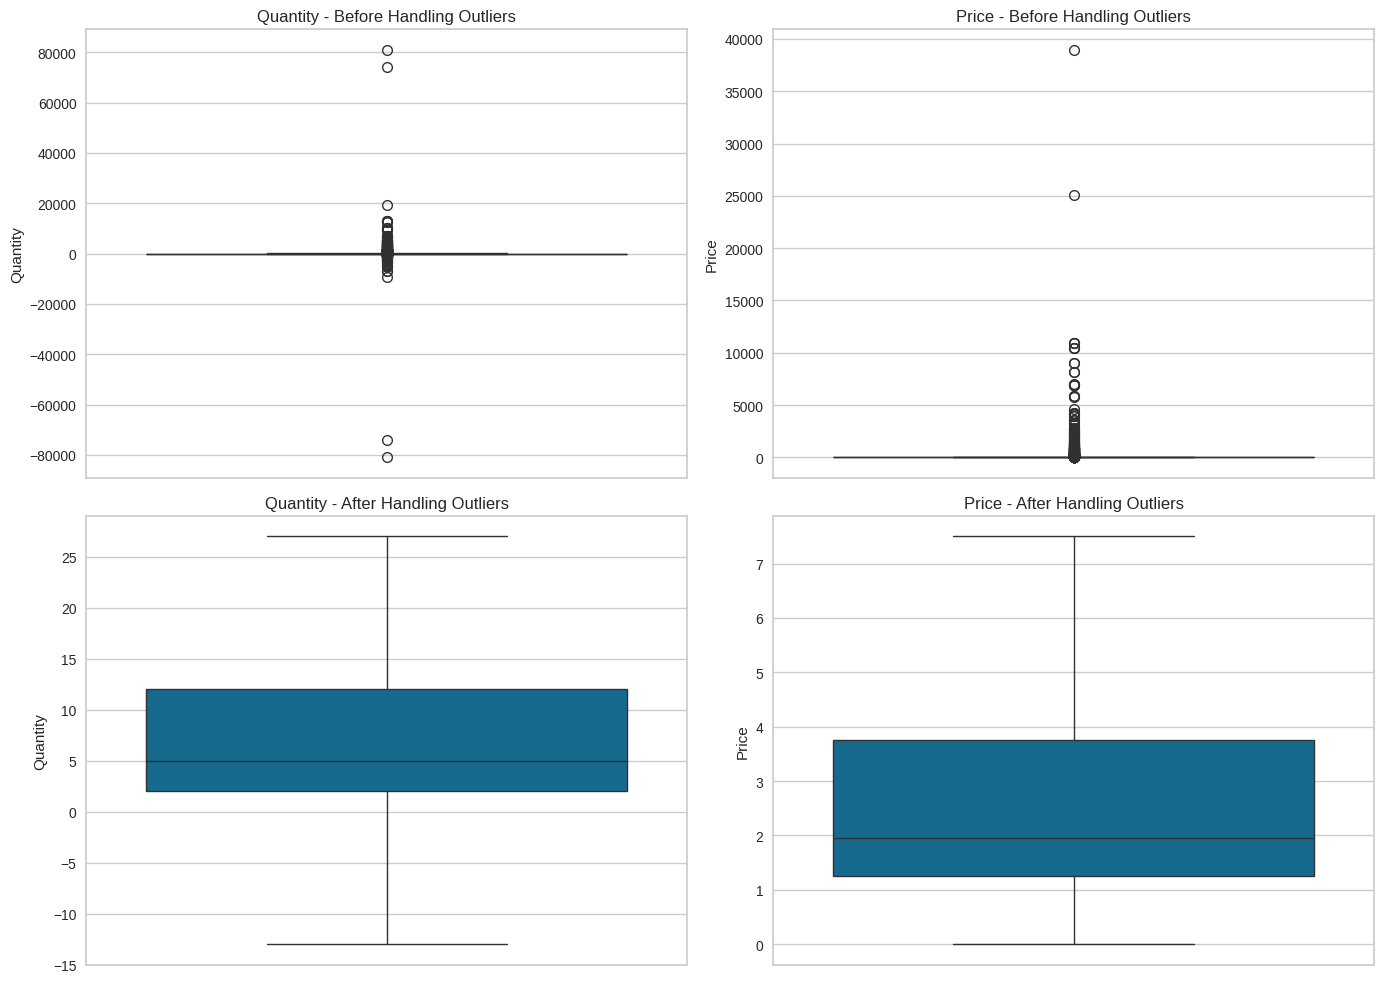

In [21]:
# Function to cap outliers using IQR
def cap_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Capping outliers instead of removing them
    data[column] = np.where(data[column] < lower_bound, lower_bound, data[column])
    data[column] = np.where(data[column] > upper_bound, upper_bound, data[column])

# Create subplots for better visualization (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot boxplot for Quantity (Before Handling Outliers)
sns.boxplot(y=data['Quantity'], ax=axes[0, 0])
axes[0, 0].set_title("Quantity - Before Handling Outliers")

# Plot boxplot for Price (Before Handling Outliers)
sns.boxplot(y=data['Price'], ax=axes[0, 1])
axes[0, 1].set_title("Price - Before Handling Outliers")

# Apply IQR capping to Quantity and Price
cap_outliers(data, 'Quantity')
cap_outliers(data, 'Price')

# Plot boxplot for Quantity (After Handling Outliers)
sns.boxplot(y=data['Quantity'], ax=axes[1, 0])
axes[1, 0].set_title("Quantity - After Handling Outliers")

# Plot boxplot for Price (After Handling Outliers)
sns.boxplot(y=data['Price'], ax=axes[1, 1])
axes[1, 1].set_title("Price - After Handling Outliers")

# Display the plots
plt.tight_layout()
plt.show()

#Converting Data Types (if needed)
#### - Kept the **Invoice** column as a string because it contains characters like "C" for canceled transactions and same in **StockCode**
#### - Converted **Quantity** to integer (`int64`) after ensuring there were no decimal values, as quantities are whole numbers.
#### - Converted **Customer ID** to integer (`Int64`).
#### - Other columns (InvoiceDate, Price, and Country) were already in the correct data types.


In [22]:
# Check current data types
print("Before conversion:\n", data.dtypes)

Before conversion:
 Invoice                object
StockCode              object
Description            object
Quantity              float64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object


In [23]:
# Convert Quantity to integer
data['Quantity'] = data['Quantity'].astype(int)

# Convert Customer ID to integer, preserving NaN values
data['Customer ID'] = pd.to_numeric(data['Customer ID'], errors='coerce').astype('Int64')

# Verify the conversion
print("\nAfter conversion:\n", data.dtypes)


After conversion:
 Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID             Int64
Country                object
dtype: object


#Now Data is ready

#EDA : Feature Engineering

# 📊 RFM Analysis - Customer Segmentation
RFM (Recency, Frequency, and Monetary) analysis helps us identify different customer segments based on their purchasing behavior.
####🔹 Recency (R): The number of days since the customer's last purchase.
####🔹 Frequency (F): The total number of purchases made by the customer.
####🔹 Monetary (M): The total revenue generated by each customer.

## ❌ Why I Ignored Cancelled Transactions in RFM?  
#### - **Recency**: A cancelled transaction doesn’t indicate a real purchase, so it shouldn't affect the last purchase date.  
#### - **Frequency**: Counting cancelled invoices would falsely inflate the number of purchases.  
#### - **Monetary**: A cancelled transaction means the customer was refunded or did not complete the purchase, so including negative revenue would distort actual spending.  
### ✅ Excluding cancellations ensures accurate customer behavior analysis.  


In [24]:
# Creating new feature Revenue (Quantity * Price) to calculate total spending per transaction.
data["Revenue"] = data["Quantity"] * data["Price"]
print("Max date :",data["InvoiceDate"].max())
print("Min date :",data["InvoiceDate"].min())

Max date : 2011-12-09 12:50:00
Min date : 2009-12-01 07:45:00


In [25]:
# Creating Features for RFM Model
# Set Latest date 2011-12-10 as last invoice date was 2011-12-09.
Latest_Date = dt.datetime(2011,12,10)

# Ignore canceled transactions (Quantity < 0)
valid_purchases = data[data["Quantity"] > 0]

# Compute RFM metrics
RFM = valid_purchases.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (Latest_Date - x.max()).days,  # Recency (days since last purchase)
    'Invoice': lambda x: x.nunique(),  # Frequency (number of purchases)
    'Revenue': lambda x: x.sum()  # Monetary (total spending)
})

# Rename columns
RFM.rename(columns={'InvoiceDate': 'Recency',
                    'Invoice': 'Frequency',
                    'Revenue': 'Monetary'}, inplace=True)

# Reset index
RFM = RFM.reset_index()#(Now Customer ID is a normal column, and the DataFrame has a default numeric index.)

# Style the RFM table for better readability and aesthetics
styled_RFM = RFM.head(5).style.set_properties(**{
    "background-color": "white",
    "color": "black",
    "border-color": "black",
    "text-align": "center"
}).set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#87CEEB'), ('color', 'black'), ('font-weight', 'bold')]},  # Baby Blue Headers
    {'selector': 'tbody th', 'props': [('background-color', '#87CEEB'), ('color', 'black'), ('font-weight', 'bold')]},  # Row Headers
    {'selector': 'td', 'props': [('padding', '8px'), ('border', '1px solid black')]},  # Cell Styling
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#F5F5F5')]}  # Light Gray Alternate Row Color
])

# Display styled_RFM
display(styled_RFM)

,Customer ID,Recency,Frequency,Monetary
0,12346,325,12,400.940000
1,12347,2,8,4473.220000
2,12348,75,5,779.730000
3,12349,18,4,3347.990000
4,12350,310,1,301.900000


#RFMT Model
##Interpurchase Time (T)
Interpurchase Time (T) represents the average time between a customer's purchases. It helps analyze customer purchasing patterns and is useful in predicting future purchases.
####T = L/(F-1) = (Tn - T1)/(F-1)

#####T --> Interpurchase Time
#####L --> Shopping Cycle
#####F --> Frequency
#####T1 --> First purchase
#####Tn --> Last purchase
#####Note: Assign "nan" to customers in Interpurchase_Time who have made only one purchase.
###❌I Ignored Cancelled Transactions
Cancelled transactions do not represent real purchases. If included, they would distort the average time between actual purchases, making Interpurchase Time unreliable.


In [26]:
# Compute Shopping Cycle (L)
Shopping_Cycle = valid_purchases.groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (x.max() - x.min()).days  # Shopping Cycle (Tn - T1)
})

# Rename and merge with RFM
Shopping_Cycle.rename(columns={"InvoiceDate": "Shopping_Cycle"}, inplace=True)
RFM = RFM.merge(Shopping_Cycle, on="Customer ID", how="left")
RFM.head()

,Customer ID,Recency,Frequency,Monetary,Shopping_Cycle
0,12346,325,12,400.94,400
1,12347,2,8,4473.22,402
2,12348,75,5,779.73,362
3,12349,18,4,3347.99,570
4,12350,310,1,301.90,0


In [27]:
# Ensure Frequency and Shopping_Cycle is Integers
RFM["Frequency"] = RFM["Frequency"].astype(int)
RFM["Shopping_Cycle"] = RFM["Shopping_Cycle"].astype(int)

# Compute Interpurchase Time (T)
RFM["Interpurchase_Time"] = RFM.apply(
    lambda row: (row["Shopping_Cycle"] // (row["Frequency"] - 1)) if row["Frequency"] > 1 else None, axis=1
)

# Final RFMT Table
RFMT = RFM[["Customer ID","Recency", "Frequency", "Monetary", "Interpurchase_Time"]]

# Display Table with Styling
styled_RFMT = RFMT.head(5).style.set_properties(**{
    "background-color": "white",
    "color": "black",
    "border-color": "black",
    "text-align": "center"
}).set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#87CEEB'), ('color', 'black'), ('font-weight', 'bold')]},  # Baby Blue Headers
    {'selector': 'tbody th', 'props': [('background-color', '#87CEEB'), ('color', 'black'), ('font-weight', 'bold')]},  # Row Headers
    {'selector': 'td', 'props': [('padding', '8px'), ('border', '1px solid black')]},  # Cell Styling
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#F5F5F5')]}  # Light Gray Alternate Row Color
])

# Display styled_RFMT
display(styled_RFMT)

,Customer ID,Recency,Frequency,Monetary,Interpurchase_Time
0,12346,325,12,400.940000,36.000000
1,12347,2,8,4473.220000,57.000000
2,12348,75,5,779.730000,90.000000
3,12349,18,4,3347.990000,190.000000
4,12350,310,1,301.900000,nan


In [28]:
RFMT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer ID         5881 non-null   Int64  
 1   Recency             5881 non-null   int64  
 2   Frequency           5881 non-null   int64  
 3   Monetary            5881 non-null   float64
 4   Interpurchase_Time  4255 non-null   float64
dtypes: Int64(1), float64(2), int64(2)
memory usage: 235.6 KB


#CFMT Model for Customer Segmentation
#### CFMT helps analyze customer behavior related to cancellations, providing insights into:
####🔹 CRecency: Days since the customer's last cancellation.
####🔹 CFrequency: Total number of cancellation transactions per customer.
####🔹 CMonetary: Total revenue lost due to cancellations.
####🔹 CTime: Average time between cancellations for each customer.

In [29]:
# Set Latest date 2011-12-10 as last invoice date was 2011-12-09.
Latest_Date = dt.datetime(2011, 12, 10)

# Filter Only Cancelled Transactions (Assume cancellations have negative 'Quantity')
cancelled_orders = data[data["Quantity"] < 0].copy()

# Compute CFM Metrics
CFM = cancelled_orders.groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (Latest_Date - x.max()).days,  # CRecency (Days since last cancellation)
    "Invoice": lambda x: x.nunique(),  # CFrequency (Number of unique cancellations)
    "Quantity": lambda x: (x.abs() * cancelled_orders.loc[x.index, "Price"]).sum()  # CMonetary (Total revenue lost)
}).rename(columns={"InvoiceDate": "CRecency", "Invoice": "CFrequency", "Quantity": "CMonetary"}).reset_index()

# Apply Styling
styled_CFM = CFM.head(5).style.set_properties(**{
    "background-color": "white",
    "color": "black",
    "border-color": "black",
    "text-align": "center"
}).set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#87CEEB'), ('color', 'black'), ('font-weight', 'bold')]},  # Baby Blue Headers
    {'selector': 'tbody th', 'props': [('background-color', '#87CEEB'), ('color', 'black'), ('font-weight', 'bold')]},  # Row Headers
    {'selector': 'td', 'props': [('padding', '8px'), ('border', '1px solid black')]},  # Cell Styling
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#F5F5F5')]}  # Light Gray Alternate Row Color
])

# Display styled_CFM
display(styled_CFM)

,Customer ID,CRecency,CFrequency,CMonetary
0,12346,325,5,120.010000
1,12349,735,1,16.700000
2,12352,262,3,142.830000
3,12359,7,4,88.670000
4,12360,563,1,7.500000


In [30]:
# Compute Cancellation Cycle (Tn - T1) in days
Cancellation_Cycle = cancelled_orders.groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (x.max() - x.min()).days
}).rename(columns={"InvoiceDate": "Cancellation_Cycle"})

# Merge with CFM
CFM = CFM.merge(Cancellation_Cycle, on="Customer ID", how="left")
CFM.head()

,Customer ID,CRecency,CFrequency,CMonetary,Cancellation_Cycle
0,12346,325,5,120.01,356
1,12349,735,1,16.70,0
2,12352,262,3,142.83,21
3,12359,7,4,88.67,715
4,12360,563,1,7.50,0


In [31]:
# Ensure CFrequency and Cancellation_Cycle are Integers
CFM["CFrequency"] = CFM["CFrequency"].astype(int)
CFM["Cancellation_Cycle"] = CFM["Cancellation_Cycle"].astype(int)

# Compute CTime (Average time between cancellations)
CFM["CTime"] = CFM.apply(
    lambda row: (row["Cancellation_Cycle"] // (row["CFrequency"] - 1)) if row["CFrequency"] > 1 else None, axis=1
)
# Create CFMT
CFMT = CFM[["Customer ID","CRecency", "CFrequency", "CMonetary", "CTime"]]

# Apply Styling
styled_CFMT = CFMT.head(5).style.set_properties(**{
    "background-color": "white",
    "color": "black",
    "border-color": "black",
    "text-align": "center"
}).set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#87CEEB'), ('color', 'black'), ('font-weight', 'bold')]},  # Baby Blue Headers
    {'selector': 'tbody th', 'props': [('background-color', '#87CEEB'), ('color', 'black'), ('font-weight', 'bold')]},  # Row Headers
    {'selector': 'td', 'props': [('padding', '8px'), ('border', '1px solid black')]},  # Cell Styling
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#F5F5F5')]}  # Light Gray Alternate Row Color
])

# Display styled_CFMT
display(styled_CFMT)

,Customer ID,CRecency,CFrequency,CMonetary,CTime
0,12346,325,5,120.010000,89.000000
1,12349,735,1,16.700000,nan
2,12352,262,3,142.830000,10.000000
3,12359,7,4,88.670000,238.000000
4,12360,563,1,7.500000,nan


#RFMT Bucketing and Normalization
###Convert RFMT metrics into categorical scores (1 to 4) for better customer segmentation.
####Recency (R): More recent purchase → Higher score
####Frequency (F): More purchases → Higher score
####Monetary (M): Higher spending → Higher score
####Interpurchase Time (T): Shorter time between purchases → Higher score

In [32]:
# Display missing values in each column
RFMT.isnull().sum()

,0
Customer ID,0
Recency,0
Frequency,0
Monetary,0
Interpurchase_Time,1626


In [33]:
# Fill NaN in Interpurchase_Time with a large value (e.g., max gap)
# This means: If a customer has only 1 transaction and no time gap, treat them as "least frequent" buyer (makes sense for segmentation).
# Get max Interpurchase_Time (gap) from RFMT
max_gap_t = RFMT['Interpurchase_Time'].max()

# Safely fill NaNs using .loc to avoid SettingWithCopyWarning
RFMT.loc[:, 'Interpurchase_Time'] = RFMT['Interpurchase_Time'].fillna(max_gap_t + 1)

# Check for missing values again
print(RFMT.isnull().sum())

Customer ID           0
Recency               0
Frequency             0
Monetary              0
Interpurchase_Time    0
dtype: int64


In [34]:
# Loop through each column in RFMT
for col in RFMT.columns:
    print(f"\n--- {col} ---")
    print(f"Unique values: {RFMT[col].nunique()}")
    print("Value counts:")
    print(RFMT[col].value_counts().sort_index())


--- Customer ID ---
Unique values: 5881
Value counts:
Customer ID
12346    1
12347    1
12348    1
12349    1
12350    1
        ..
18283    1
18284    1
18285    1
18286    1
18287    1
Name: count, Length: 5881, dtype: Int64

--- Recency ---
Unique values: 593
Value counts:
Recency
0       35
1      103
2       90
3       94
4       94
      ... 
734      1
735      6
736      6
737      7
738      5
Name: count, Length: 593, dtype: int64

--- Frequency ---
Unique values: 90
Value counts:
Frequency
1      1626
2       944
3       664
4       486
5       360
       ... 
203       1
208       1
211       1
337       1
398       1
Name: count, Length: 90, dtype: int64

--- Monetary ---
Unique values: 5740
Value counts:
Monetary
0.00         3
2.95         1
3.75         2
4.59         1
5.13         1
            ..
89361.78     1
91425.89     1
121655.52    1
158928.51    1
232375.50    1
Name: count, Length: 5740, dtype: int64

--- Interpurchase_Time ---
Unique values: 436
Value coun

In [35]:
# Function to apply quantile-based bucketing for RFMT metrics
def bucketing_normalization(df: pd.DataFrame, feature: str, new_col_name: str, n_buckets: int, default_label_order: list):
    """
    Apply quantile-based bucketing to normalize RFMT metrics.

    Parameters:
    df (pd.DataFrame)         : The DataFrame containing RFMT metrics.
    feature (str)             : The column name to apply bucketing on.
    new_col_name (str)        : The name for the new normalized column (R, F, M, T).
    n_buckets (int)           : Requested number of quantile buckets.
    default_label_order (list): Desired label order (higher score = better).

    Returns:
    df (pd.DataFrame)         : The DataFrame with a new bucketed column.
    """
    # Ensure feature exists in the DataFrame
    if feature not in df.columns:
        raise ValueError(f"Feature '{feature}' not found in DataFrame.")
    # if qcut fails because there aren’t enough unique values, just figure out how many buckets you actually ended up with, and cut the label list to match.
    # Try to split into 4 groups using qcut().
    # If that fails, check how many groups were actually created.
    # Use the same number of labels as groups — no mismatch, no error.
    try:
        # Apply quantile-based bucketing
        df[new_col_name] = pd.qcut(df[feature], q=n_buckets, labels=default_label_order, duplicates='drop')
    except ValueError as e:
        # If label mismatch occurs, get actual bins and adjust labels accordingly
        bins = pd.qcut(df[feature], q=n_buckets, retbins=True, duplicates='drop')[1]
        adjusted_labels = default_label_order[:len(bins) - 1]
        df[new_col_name] = pd.qcut(df[feature], q=n_buckets, labels=adjusted_labels, duplicates='drop')

    return df

# APPLY BUCKETING TO EACH RFMT METRIC (Creating New Columns: R, F, M, T)
RFMT = bucketing_normalization(RFMT, 'Recency', 'R', 4, range(4, 0, -1))  # Recent purchases (lower value) = Higher score
RFMT = bucketing_normalization(RFMT, 'Frequency', 'F', 4, range(1, 5))  # More purchases = Higher score
RFMT = bucketing_normalization(RFMT, 'Monetary', 'M', 4, range(1, 5))   # Higher spending = Higher score
RFMT = bucketing_normalization(RFMT, 'Interpurchase_Time', 'T', 4, range(4, 0, -1))  # Frequent purchases (lower gap) = Higher score

# Set Customer ID as index
RFMT.set_index('Customer ID', inplace=True)

# Show the first few rows after bucketing
print(RFMT.head())

             Recency  Frequency  Monetary  Interpurchase_Time  R  F  M  T
Customer ID                                                              
12346            325         12    400.94                36.0  2  3  2  4
12347              2          8   4473.22                57.0  4  3  4  3
12348             75          5    779.73                90.0  3  2  3  3
12349             18          4   3347.99               190.0  4  2  4  2
12350            310          1    301.90               715.0  2  1  2  2


In [36]:
# Final Feature Matrix
X_RFMT = RFMT[['R', 'F', 'M', 'T']]

# Show the first few rows after bucketing
print(X_RFMT.head())

             R  F  M  T
Customer ID            
12346        2  3  2  4
12347        4  3  4  3
12348        3  2  3  3
12349        4  2  4  2
12350        2  1  2  2


In [37]:
# Loop through each column in X_RFMT
for col in X_RFMT.columns:
    print(f"\n--- {col} ---")
    print(f"Unique values: {X_RFMT[col].nunique()}")
    print("Value counts:")
    print(X_RFMT[col].value_counts().sort_index())


--- R ---
Unique values: 4
Value counts:
R
4    1488
3    1460
2    1464
1    1469
Name: count, dtype: int64

--- F ---
Unique values: 3
Value counts:
F
1    3234
2    1348
3    1299
Name: count, dtype: int64

--- M ---
Unique values: 4
Value counts:
M
1    1471
2    1470
3    1470
4    1470
Name: count, dtype: int64

--- T ---
Unique values: 3
Value counts:
T
4    1482
3    1470
2    2929
Name: count, dtype: int64


In [38]:
X_RFMT.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5881 entries, 12346 to 18287
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   R       5881 non-null   category
 1   F       5881 non-null   category
 2   M       5881 non-null   category
 3   T       5881 non-null   category
dtypes: category(4)
memory usage: 75.2 KB


# CFMT Bucketing and Normalization
#### Convert CFMT metrics into categorical scores (1 to 4) for better segmentation of cancellation behavior.
##### CRecency (C): More recent cancellations → Lower score (1), less recent → Higher score (4)
##### CFrequency (F): More frequent cancellations → Lower score (1), less frequent → Higher score (3)
##### CMonetary (M): Higher refund amounts → Lower score (1), lower refunds → Higher score (4)
##### CTime (T): Longer time between cancellations → Higher score (3), shorter time → Lower score (1)

In [39]:
# Display missing values in each column
CFMT.isnull().sum()

,0
Customer ID,0
CRecency,0
CFrequency,0
CMonetary,0
CTime,1158


In [40]:
# Fill NaN in CTime with a  large value (e.g., max gap)
# This means: if the client has only one cancellation and there is no time gap, treat it as a "less frequent" cancellation (makes sense for segmentation).
# Get max CTime (gap) from CFMT
max_gap_ct = CFMT['CTime'].max()

# Safely fill NaNs using .loc to avoid SettingWithCopyWarning
CFMT.loc[:, 'CTime'] = CFMT['CTime'].fillna(max_gap_ct + 1)

# Check for missing values again
print(CFMT.isnull().sum())

Customer ID    0
CRecency       0
CFrequency     0
CMonetary      0
CTime          0
dtype: int64


In [41]:
# Loop through each column in CFMT
for col in CFMT.columns:
    print(f"\n--- {col} ---")
    print(f"Unique values: {CFMT[col].nunique()}")
    print("Value counts:")
    print(CFMT[col].value_counts().sort_index())


--- Customer ID ---
Unique values: 2572
Value counts:
Customer ID
12346    1
12349    1
12352    1
12359    1
12360    1
        ..
18280    1
18282    1
18284    1
18286    1
18287    1
Name: count, Length: 2572, dtype: Int64

--- CRecency ---
Unique values: 516
Value counts:
CRecency
0       5
1      20
2      13
3      28
4      13
       ..
733     4
735     2
736     1
737     2
738    13
Name: count, Length: 516, dtype: int64

--- CFrequency ---
Unique values: 38
Value counts:
CFrequency
1      1158
2       528
3       293
4       187
5        98
6        84
7        41
8        35
9        23
10       21
11       21
12       16
13       10
14        9
15        4
16        5
17        2
18        4
19        2
20        4
21        3
22        2
23        3
25        2
26        1
28        1
29        3
33        1
37        2
38        1
44        1
46        1
50        1
62        1
67        1
68        1
78        1
112       1
Name: count, dtype: int64

--- CMonetary ---

In [42]:
# APPLY BUCKETING TO EACH CFMT METRIC
CFMT = bucketing_normalization(CFMT, 'CRecency', 'C', 4, range(1, 5))   # Recent cancellations (lower value) = Low score (1)
CFMT = bucketing_normalization(CFMT, 'CFrequency', 'F', 4, range(4, 0, -1))  # Frequent cancellations = Low score (1)
CFMT = bucketing_normalization(CFMT, 'CMonetary', 'M', 4, range(4, 0, -1))   # High refund value = Low score (1)
CFMT = bucketing_normalization(CFMT, 'CTime', 'T', 4, range(1, 5)) # lower time between cancels = Low score (1)

# Set Customer ID as the index
CFMT.set_index('Customer ID', inplace=True)

# Show the first few rows after bucketing
print(CFMT.head())

             CRecency  CFrequency  CMonetary  CTime  C  F  M  T
Customer ID                                                    
12346             325           5     120.01   89.0  3  2  1  2
12349             735           1      16.70  733.0  4  4  3  3
12352             262           3     142.83   10.0  3  3  1  1
12359               7           4      88.67  238.0  1  2  1  2
12360             563           1       7.50  733.0  4  4  4  3


In [43]:
# Final Feature Matrix
X_CFMT = CFMT[['C', 'F', 'M', 'T']]

# Show the first few rows after bucketing
print(X_CFMT.head())

             C  F  M  T
Customer ID            
12346        3  2  1  2
12349        4  4  3  3
12352        3  3  1  1
12359        1  2  1  2
12360        4  4  4  3


In [44]:
# Loop through each column in X_CFMT
for col in X_CFMT.columns:
    print(f"\n--- {col} ---")
    print(f"Unique values: {X_CFMT[col].nunique()}")
    print("Value counts:")
    print(X_CFMT[col].value_counts().sort_index())


--- C ---
Unique values: 4
Value counts:
C
1    645
2    642
3    644
4    641
Name: count, dtype: int64

--- F ---
Unique values: 3
Value counts:
F
4    1686
3     293
2     593
Name: count, dtype: int64

--- M ---
Unique values: 4
Value counts:
M
4    643
3    648
2    638
1    643
Name: count, dtype: int64

--- T ---
Unique values: 3
Value counts:
T
1     652
2     635
3    1285
Name: count, dtype: int64


In [45]:
X_CFMT.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2572 entries, 12346 to 18287
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   C       2572 non-null   category
 1   F       2572 non-null   category
 2   M       2572 non-null   category
 3   T       2572 non-null   category
dtypes: category(4)
memory usage: 33.2 KB


#Merge RFMT and CFMT
#### Merge RFMT and CFMT on 'Customer ID' to combine purchase behavior and cancellation behavior  
##### - Use **left** join to keep all customers from X_RFMT and add X_CFMT data where available.
##### - If a customer exists in X_RFMT but not in X_CFMT, their X_CFMT values will be NaN.
##### - Rename X_CFMT columns  
##### - Fill missing X_CFMT values with **4**, since no cancellations mean the best behavior  

In [46]:
# Merge X_RFMT and X_CFMT on 'Customer ID'
X = X_RFMT.merge(X_CFMT, left_index=True, right_index=True, how='left')
X = X.rename(columns={
    'R': 'R',
    'F_x': 'F',
    'M_x': 'M',
    'T_x': 'T',
    'C': 'CR',
    'F_y': 'CF',
    'M_y': 'CM',
    'T_y': 'CT'
})

# Add '4' to the categories of CFMT columns only if not already present, then fill NaN with 4
for col in ['CR', 'CF', 'CM', 'CT']:
    if 4 not in X[col].cat.categories:
        X[col] = X[col].cat.add_categories([4])
    X[col] = X[col].fillna(4)

# Display the first few rows
X.head()

,R,F,M,T,CR,CF,CM,CT
Customer ID,,,,,,,,
12346,2,3,2,4,3,2,1,2
12347,4,3,4,3,4,4,4,4
12348,3,2,3,3,4,4,4,4
12349,4,2,4,2,4,4,3,3
12350,2,1,2,2,4,4,4,4


In [47]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5881 entries, 12346 to 18287
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   R       5881 non-null   category
 1   F       5881 non-null   category
 2   M       5881 non-null   category
 3   T       5881 non-null   category
 4   CR      5881 non-null   category
 5   CF      5881 non-null   category
 6   CM      5881 non-null   category
 7   CT      5881 non-null   category
dtypes: category(8)
memory usage: 98.7 KB


#Modelling with KMeans Algorithm


##Importing Required Libraries

In [48]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

In [49]:
# Convert 'category' columns to integer (required for KMeans)
# KMeans needs numerical data, not categorical. Converting them to int is fast and safe
for col in X.columns:
    if X[col].dtype.name == 'category':
        X[col] = X[col].astype(int)

In [50]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5881 entries, 12346 to 18287
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   R       5881 non-null   int64
 1   F       5881 non-null   int64
 2   M       5881 non-null   int64
 3   T       5881 non-null   int64
 4   CR      5881 non-null   int64
 5   CF      5881 non-null   int64
 6   CM      5881 non-null   int64
 7   CT      5881 non-null   int64
dtypes: int64(8)
memory usage: 419.3 KB


##Choosing the best k (number of clusters) for customer segmentation.

In [51]:
# Try Different k (Clusters) from 3 to 6
# Store Silhouette and Davies-Bouldin scores
evaluation = []

for k in range(3, 7):
    # Apply KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)

    # Compute evaluation metrics
    sil_score = silhouette_score(X, labels)
    db_score = davies_bouldin_score(X, labels)

    evaluation.append((k, sil_score, db_score))

    print(f"k={k} | Silhouette Score = {sil_score:.3f} | Davies-Bouldin Score = {db_score:.3f}")

k=3 | Silhouette Score = 0.305 | Davies-Bouldin Score = 1.308
k=4 | Silhouette Score = 0.295 | Davies-Bouldin Score = 1.452
k=5 | Silhouette Score = 0.281 | Davies-Bouldin Score = 1.355
k=6 | Silhouette Score = 0.293 | Davies-Bouldin Score = 1.325


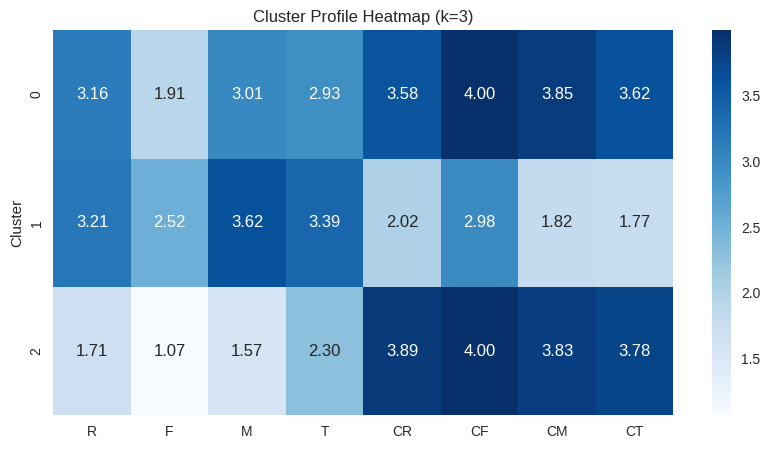

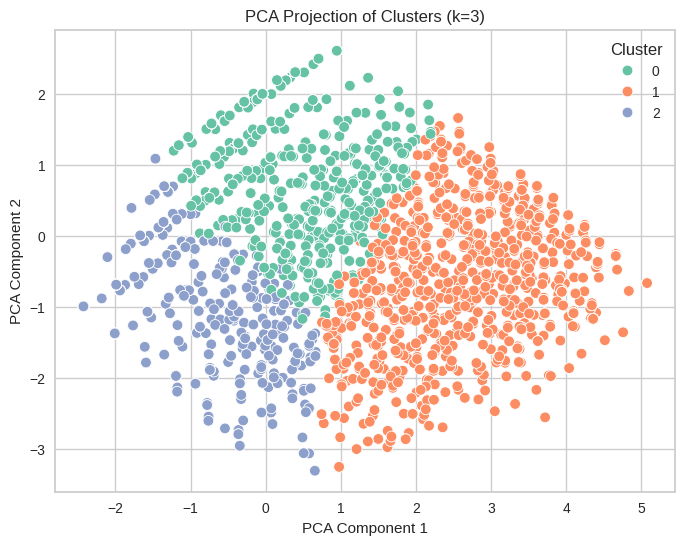

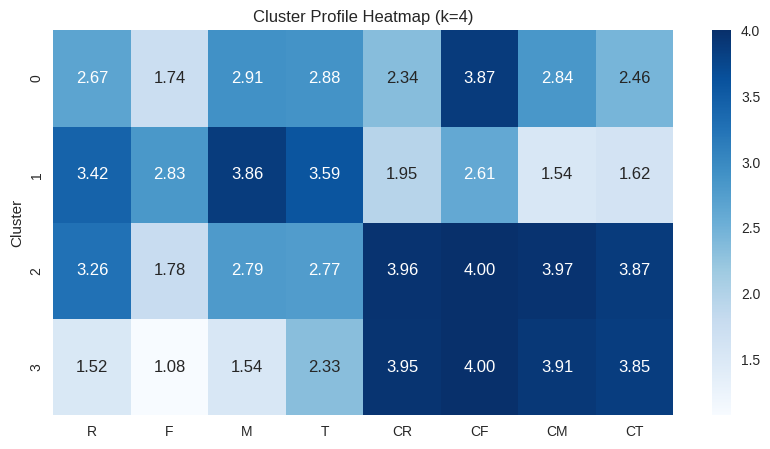

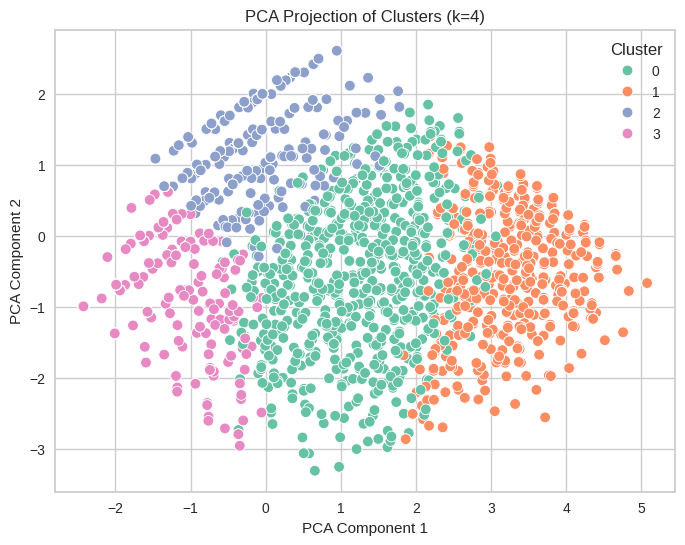

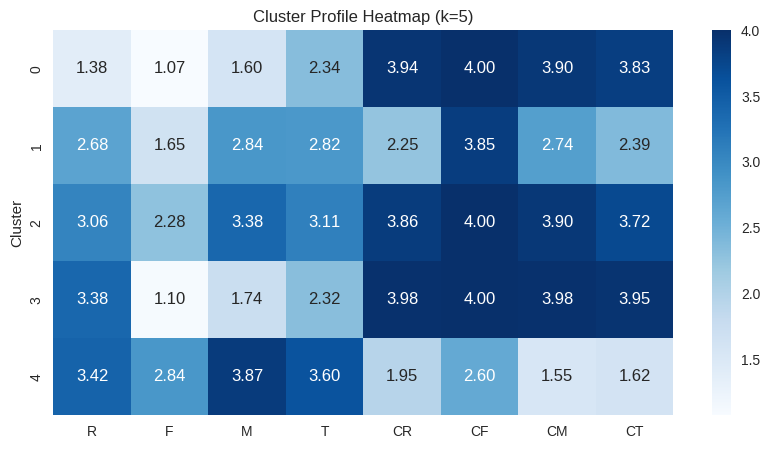

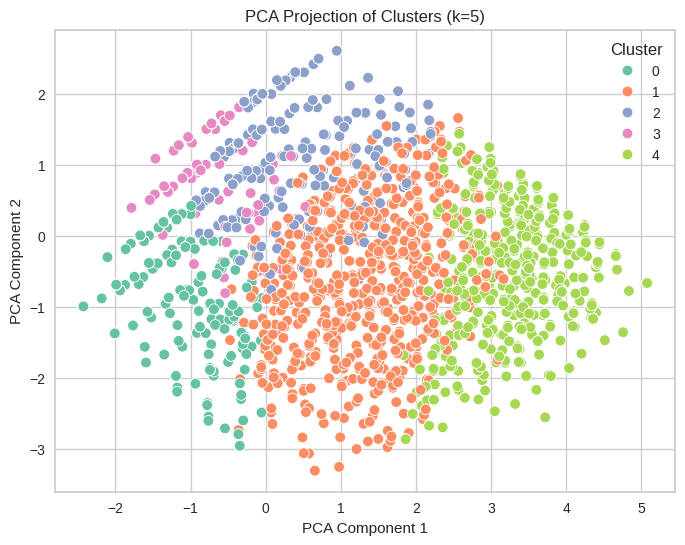

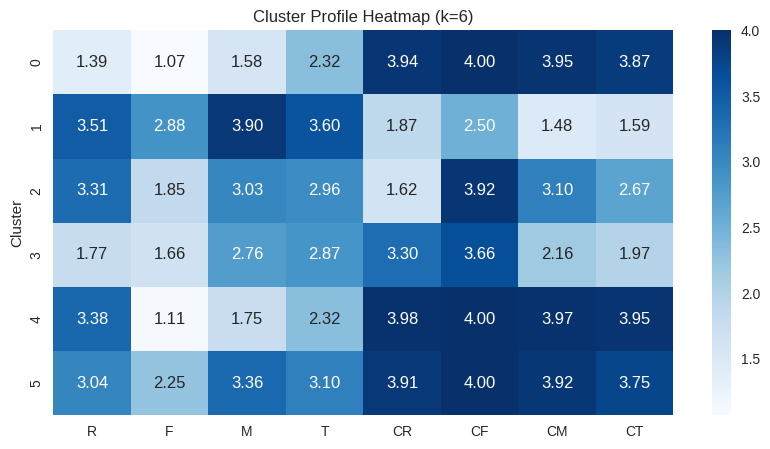

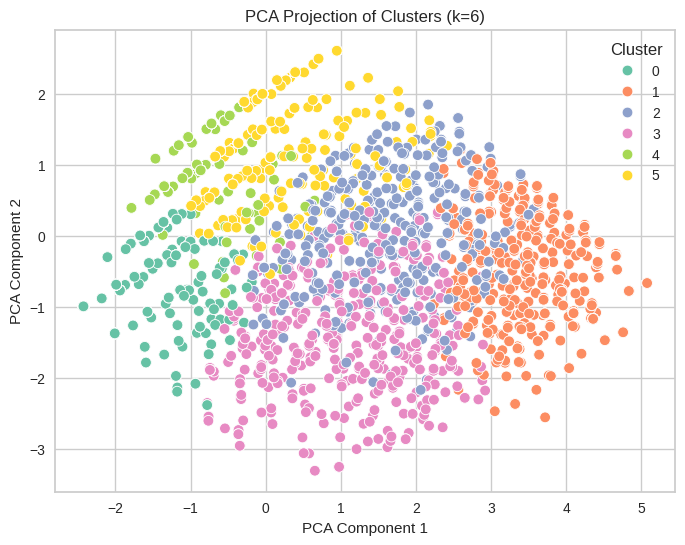

In [52]:
# Visualize Each Cluster's Profile and PCA Plot
for k in range(3, 7):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)

    # Add cluster labels
    X_with_cluster = X.copy()
    X_with_cluster['Cluster'] = labels

    # Cluster Profile Heatmap
    cluster_profile = X_with_cluster.groupby('Cluster').mean()

    plt.figure(figsize=(10, 5))
    sns.heatmap(cluster_profile, annot=True, fmt=".2f", cmap="Blues")
    plt.title(f"Cluster Profile Heatmap (k={k})")
    plt.show()

    # PCA for 2D Visualization
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette="Set2", s=60)
    plt.title(f"PCA Projection of Clusters (k={k})")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title="Cluster")
    plt.grid(True)
    plt.show()


In [53]:
# Show Summary Table of All Cluster Evaluations
eval_df = pd.DataFrame(evaluation, columns=["k", "Silhouette Score", "Davies-Bouldin Score"])
print("Evaluation Summary (Lower DB Score & Higher Silhouette Score are Better):")
print(eval_df.round(3))

Evaluation Summary (Lower DB Score & Higher Silhouette Score are Better):
   k  Silhouette Score  Davies-Bouldin Score
0  3             0.305                 1.308
1  4             0.295                 1.452
2  5             0.281                 1.355
3  6             0.293                 1.325


##KMeans Model with Best k=3

In [54]:
# original DataFrame with real values not scores
RFMT_CFMT = RFMT.merge(CFMT, left_index=True, right_index=True, how='left')
RFMT_CFMT = RFMT_CFMT[[
    'Recency', 'Frequency', 'Monetary', 'Interpurchase_Time',
    'CRecency', 'CFrequency', 'CMonetary', 'CTime'
]]

In [55]:
RFMT_CFMT.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5881 entries, 12346 to 18287
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Recency             5881 non-null   int64  
 1   Frequency           5881 non-null   int64  
 2   Monetary            5881 non-null   float64
 3   Interpurchase_Time  5881 non-null   float64
 4   CRecency            2511 non-null   float64
 5   CFrequency          2511 non-null   float64
 6   CMonetary           2511 non-null   float64
 7   CTime               2511 non-null   float64
dtypes: float64(6), int64(2)
memory usage: 419.3 KB


In [56]:
# Fit Final KMeans Model (k=3) on Normalized Data
final_k = 3  # Optimal number of clusters
final_kmeans = KMeans(n_clusters=final_k, random_state=42, n_init=10)
final_labels = final_kmeans.fit_predict(X)  # X is the normalized RFMT+CFMT feature matrix

# Assign Cluster Labels to Original Data (Real Values)
RFMT_CFMT['Cluster'] = final_labels  # Add cluster label to real RFMT+CFMT data

# Show number of customers per cluster
cluster_counts = RFMT_CFMT['Cluster'].value_counts().sort_index()
print("Customer Count per Cluster:")
print(cluster_counts)

# Display Cluster Centers (from Normalized Data)
cluster_centers = pd.DataFrame(final_kmeans.cluster_centers_, columns=X.columns)
cluster_centers.index.name = "Cluster"

print("\nCluster Centers (Normalized Features):")
display(cluster_centers.round(2))

Customer Count per Cluster:
Cluster
0    1761
1    1427
2    2693
Name: count, dtype: int64

Cluster Centers (Normalized Features):


,R,F,M,T,CR,CF,CM,CT
Cluster,,,,,,,,
0,3.15,1.91,3.01,2.93,3.57,4.00,3.85,3.62
1,3.21,2.52,3.62,3.39,2.02,2.97,1.81,1.77
2,1.71,1.07,1.57,2.30,3.89,4.00,3.83,3.78


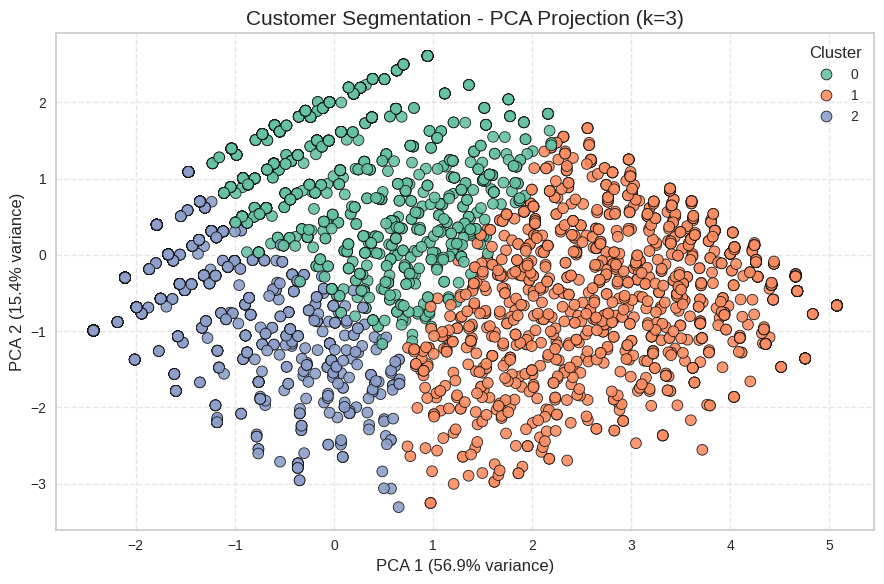

In [57]:
# 2D PCA Visualization of Clusters (on Normalized Data)
# Perform PCA on normalized features
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X)
explained_var = pca.explained_variance_ratio_ * 100  # % variance explained

# Plot 2D PCA projection with cluster labels
plt.figure(figsize=(9, 6))
sns.scatterplot(
    x=pca_result[:, 0],
    y=pca_result[:, 1],
    hue=final_labels,
    palette="Set2",
    s=60,
    alpha=0.9,
    edgecolor="k"
)
plt.title("Customer Segmentation - PCA Projection (k=3)", fontsize=15)
plt.xlabel(f"PCA 1 ({explained_var[0]:.1f}% variance)", fontsize=12)
plt.ylabel(f"PCA 2 ({explained_var[1]:.1f}% variance)", fontsize=12)
# PCA 1 explains 56.9% of the data's variance, capturing the most important patterns.
# PCA 2 explains 15.4%, capturing additional, but less significant, patterns.
plt.legend(title="Cluster", loc='best')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

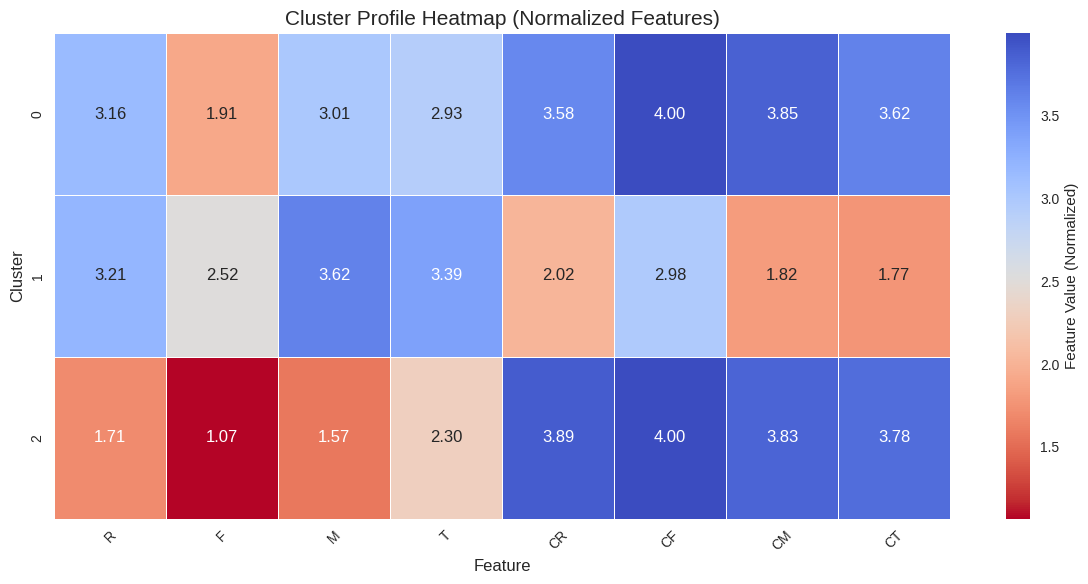

In [58]:
# Cluster Profile Heatmap (on Normalized Data)
# Add cluster labels to normalized dataset
X_with_cluster = X.copy()
X_with_cluster['Cluster'] = final_labels

# Compute mean profile per cluster
cluster_profile = X_with_cluster.groupby('Cluster').mean()

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    cluster_profile,
    annot=True,
    fmt=".2f",
    cmap="coolwarm_r",
    linewidths=0.6,
    cbar_kws={'label': 'Feature Value (Normalized)'}
)
plt.title("Cluster Profile Heatmap (Normalized Features)", fontsize=15)
plt.ylabel("Cluster", fontsize=12)
plt.xlabel("Feature", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [59]:
RFMT_CFMT.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5881 entries, 12346 to 18287
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Recency             5881 non-null   int64  
 1   Frequency           5881 non-null   int64  
 2   Monetary            5881 non-null   float64
 3   Interpurchase_Time  5881 non-null   float64
 4   CRecency            2511 non-null   float64
 5   CFrequency          2511 non-null   float64
 6   CMonetary           2511 non-null   float64
 7   CTime               2511 non-null   float64
 8   Cluster             5881 non-null   int32  
dtypes: float64(6), int32(1), int64(2)
memory usage: 442.2 KB


#clear summary
# ---------------------------------------
## Final K-Means Clustering Summary (k=3)
#### After evaluating different cluster counts, k=3 was selected as the optimal number of clusters.
#### We applied KMeans clustering and assigned each customer to one of the 3 clusters.

## 📊 Cluster Distribution:
#### - Cluster 0: 1,761 customers
#### - Cluster 1: 1,427 customers
#### - Cluster 2: 2,693 customers

## 🔍 Cluster Profiles:
### - Each cluster shows distinct averages across RFMT + CFMT features.

#### - Cluster 0 (Balanced & Satisfied Customers)
* Good scores across all metrics: R=3.15, F=1.91, M=3.01, T=2.93
* Very high scores in cancellation metrics (CR–CT ~3.6–4.0) → low cancellation risk, indicating satisfied and stable customers with minimal complaints.
* Overall: Reliable and moderately engaged group with low issues. This group shows balanced activity, decent satisfaction, and a low likelihood of cancellations.

#### - Cluster 1 (High-Value & Frequent Flyers)
* Highest R, F, and M scores (R=3.21, F=2.52, M=3.62) → recent, frequent, and high-spending customers.
* Also highest T (3.39) → frequent purchases in short periods of time.
* Moderate cancellation scores (CR–CT ~1.77–2.97) → higher cancellations, but still valuable customers.
* Overall: Profitable and active customers with high engagement, but there's still room to reduce cancellations and improve retention.

#### - Cluster 2 (Low Engagement & High Complaints)
* Lowest R, F, M (R=1.71, F=1.07, M=1.57) → least recent, infrequent, and low spenders.
* Also lowest T (2.30) → long periods of time between purchases.
* High scores in cancellation metrics (CR–CT ~3.78–4.00) → low cancellation rates, indicating (fewer recent) or (infrequent cancellations).
* Overall: This group is at risk due to poor engagement and low activity. Their low cancellations and complaints may suggest dissatisfaction, or they may simply be indifferent.

## 🧠 PCA Projection:
#### - The 2D PCA visualization shows good separation between clusters (red, green, blue),
#### - indicating that the KMeans model successfully captured meaningful differences in customer behavior.

## Conclusion:
#### - KMeans clustering with k=3 effectively segments customers into groups with unique behavioral patterns.
#### - These clusters can be used for targeted marketing strategies, retention plans, and personalization.

# ---------------------------------------


#Preparing for Dashboard
###to present project professionally using Power BI.

In [60]:
RFMT_CFMT.head()

,Recency,Frequency,Monetary,Interpurchase_Time,CRecency,CFrequency,CMonetary,CTime,Cluster
Customer ID,,,,,,,,,
12346,325,12,400.94,36.0,325.0,5.0,120.01,89.0,1
12347,2,8,4473.22,57.0,NaN,NaN,NaN,NaN,0
12348,75,5,779.73,90.0,NaN,NaN,NaN,NaN,0
12349,18,4,3347.99,190.0,735.0,1.0,16.70,733.0,0
12350,310,1,301.90,715.0,NaN,NaN,NaN,NaN,2


In [61]:
# Replace NaN in 'CFrequency' and 'CMonetary' with 0 (means no cancellation or return)
RFMT_CFMT['CFrequency'] = RFMT_CFMT['CFrequency'].fillna(0)
RFMT_CFMT['CMonetary'] = RFMT_CFMT['CMonetary'].fillna(0)

In [62]:
RFMT_CFMT.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5881 entries, 12346 to 18287
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Recency             5881 non-null   int64  
 1   Frequency           5881 non-null   int64  
 2   Monetary            5881 non-null   float64
 3   Interpurchase_Time  5881 non-null   float64
 4   CRecency            2511 non-null   float64
 5   CFrequency          5881 non-null   float64
 6   CMonetary           5881 non-null   float64
 7   CTime               2511 non-null   float64
 8   Cluster             5881 non-null   int32  
dtypes: float64(6), int32(1), int64(2)
memory usage: 442.2 KB


In [63]:
# Reset index to turn Customer ID from index into a column
RFMT_CFMT = RFMT_CFMT.reset_index()  # 'CustomerID' becomes a column

# Save the cleaned DataFrame as an Excel file
file_path = '/content/RFMT_CFMT.xlsx'
RFMT_CFMT.to_excel(file_path, index=False)  # Save to Excel without index

In [64]:
RFMT_CFMT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer ID         5881 non-null   Int64  
 1   Recency             5881 non-null   int64  
 2   Frequency           5881 non-null   int64  
 3   Monetary            5881 non-null   float64
 4   Interpurchase_Time  5881 non-null   float64
 5   CRecency            2511 non-null   float64
 6   CFrequency          5881 non-null   float64
 7   CMonetary           5881 non-null   float64
 8   CTime               2511 non-null   float64
 9   Cluster             5881 non-null   int32  
dtypes: Int64(1), float64(6), int32(1), int64(2)
memory usage: 442.4 KB


In [65]:
# Download the Excel file to your local device
from google.colab import files
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>